In [1]:
import pandas as pd
from scipy.stats import kendalltau
import pickle

In [2]:
results = pd.read_csv('results.csv', index_col = None)

In [3]:
results


,task,model,Accuracy,LEEP,NCE,LogME
0,Aircraft,ResNet-50,86.6,-0.412,-0.297,0.946
1,Aircraft,ResNet-101,85.6,-0.349,-0.244,0.948
2,Aircraft,ResNet-152,85.3,-0.308,-0.214,0.950
3,Aircraft,DenseNet-121,85.4,-0.431,-0.296,0.938
4,Aircraft,DenseNet-169,84.5,-0.340,-0.259,0.943
...,...,...,...,...,...,...
85,SUN,DenseNet-201,64.7,-2.618,-2.465,1.718
86,SUN,Inception v1,62.0,-3.153,-2.534,1.715
87,SUN,Inception v3,65.7,-2.943,-2.529,1.753
88,SUN,MobileNet v2,60.5,-2.764,-2.590,1.713


In [4]:
results.columns

Index(['task', 'model', 'Accuracy', 'LEEP', 'NCE', 'LogME'], dtype='object')

In [5]:
results['model'] = results['model'].str.replace('Inception v1', 'googlenet')
results['model'] = results['model'].str.replace('NASNet-A Mobile', 'mnasnet1_0')

In [6]:
results['model'] = results['model'].str.replace(' ','').str.replace('-','').str.lower()

In [7]:
results['model'] = results['model'].str.replace('v','_v')

In [8]:
results['task'] = results['task'].str.lower()

In [9]:
results['task'] = results['task'].str.replace('caltech','caltech101')
results['task'] = results['task'].str.replace('sun','sun397')
results['task'] = results['task'].str.replace('cars','stanfordcars')

In [10]:
results['task'].unique()

array(['aircraft', 'birdsnap', 'caltech101', 'stanfordcars', 'cifar10',
       'cifar100', 'dtd', 'pets', 'sun397'], dtype=object)

In [11]:
results_df = results
def compute_tda_measures(diagram, k=10):
    """(Your function for computing TDA measures)"""
    measures = {
        'avg_persist_inter': np.nan, 'std_persist_inter': np.nan,
        'avg_persist_intra': np.nan, 'persistence_ratio': np.nan,
        'combined_nc2_ratio': np.nan
    }
    if not diagram: return measures
    valid_pairs = [p for p in diagram if isinstance(p, (list, tuple)) and len(p) == 2 and all(isinstance(n, (int, float)) for n in p)]
    if len(valid_pairs) < k - 1: return measures
    persistences = sorted([p[1] for p in valid_pairs if p[1] != float('inf')], reverse=True)
    if len(persistences) < k - 1: return measures

    persist_inter = np.array(persistences[:k-1])
    persist_intra = np.array(persistences[k-1:])

    avg_persist_inter = np.mean(persist_inter)
    std_persist_inter = np.std(persist_inter)
    avg_persist_intra = np.mean(persist_intra) if len(persist_intra) > 0 else 0.0

    measures.update({
        'avg_persist_inter': avg_persist_inter,
        'std_persist_inter': std_persist_inter,
        'avg_persist_intra': avg_persist_intra,
    })

    if avg_persist_inter > 1e-9:
        measures['persistence_ratio'] = avg_persist_intra / avg_persist_inter
        measures['combined_nc2_ratio'] = std_persist_inter / avg_persist_inter
    return measures

# Number of classes for each dataset, from the paper's Appendix A
# --- MODIFICATION: Added 'imagenet' ---
num_classes = {
    'aircraft': 100,
    'cifar10': 10,
    'cifar100': 100,
    'dtd': 47,
    'pets': 37,
    'birdsnap':500,
    'caltech101': 101,
    'sun397': 397,
    'stanfordcars': 196,
    'imagenet': 1000  # Added for ImageNet diagrams
}

# --- Main Script ---

# Define the function to apply to each row
# --- MODIFICATION: The function is updated to handle ImageNet diagrams ---
def get_tda_for_row(row):
    """
    This function processes one row, loads the corresponding diagrams for both
    the specific task and ImageNet, computes TDA measures for both, and returns
    a SINGLE pd.Series containing all combined measures.
    """
    task = row['task']
    model = row['model']

    # --- 1. Compute TDA for the specific task ---
    task_measures = {}
    k = num_classes.get(task.lower().replace("oxfordiiit", ""))
    if k is None:

        print(f"Warning: Number of classes (k) not defined for task '{task}'")
        # Initialize with NaNs if k is not found
        task_measures = {
            'avg_persist_inter': np.nan, 'std_persist_inter': np.nan,
            'avg_persist_intra': np.nan, 'persistence_ratio': np.nan,
            'combined_nc2_ratio': np.nan
        }
    else:
        diagram_path = os.path.join("extraction_results/train", task, model, "persistence_diagram.pkl")
        print(diagram_path)
        if os.path.exists(diagram_path):
            try:
                with open(diagram_path, 'rb') as f:
                    diagram = pickle.load(f)
                    print(f'succesfully extracted persistence diagram with {len(diagram)}')
                task_measures = compute_tda_measures(diagram, k=k)
            except Exception as e:
                print(f"Error loading diagram from {diagram_path}: {e}")
        else:
            # Handle case where diagram for the task is missing
            print('we are here')
            task_measures = compute_tda_measures([], k=k)


    # --- 2. Compute TDA for the corresponding ImageNet model ---
    imagenet_raw_measures = {}
    imagenet_diagram_path = os.path.join("extraction_results/train", "imagenet", model, "persistence_diagram.pkl")

    if os.path.exists(imagenet_diagram_path):
        try:
            with open(imagenet_diagram_path, 'rb') as f:
                imagenet_diagram = pickle.load(f)
            # Use k=1000 for ImageNet
            imagenet_raw_measures = compute_tda_measures(imagenet_diagram, k=num_classes['imagenet'])
        except Exception as e:
            print(f"Error loading ImageNet diagram from {imagenet_diagram_path}: {e}")
            imagenet_raw_measures = compute_tda_measures([], k=num_classes['imagenet'])
    else:
         imagenet_raw_measures = compute_tda_measures([], k=num_classes['imagenet'])

    # Rename keys by prepending 'imagenet_'
    imagenet_measures = {f"imagenet_{key}": value for key, value in imagenet_raw_measures.items()}

    # --- 3. Combine both sets of measures and return as a Series ---
    all_measures = {**task_measures, **imagenet_measures}
    return pd.Series(all_measures)

import os
import torch
from nc_computing import calculate_nc_from_embeddings_and_labels # Import the new function

# Define the function to be applied to each row of the DataFrame
def get_nc_for_row(row):
    """
    Processes one row, constructs the path to the saved features and labels,
    and computes the NC1 score.
    """
    task = row['task']
    model = row['model']

    # Construct the file paths based on the structure from score_computing.ipynb
    # The 'train' split is specified as per the TDA extraction path logic
    base_path = os.path.join("extraction_results", "train", task, model)
    features_path = os.path.join(base_path, "features.pt")
    labels_path = os.path.join(base_path, "targets.pt")

    # Check if the required files exist before attempting to calculate
    if os.path.exists(features_path) and os.path.exists(labels_path):
        # Use 'cuda' if available, otherwise 'cpu'
        device = "cuda" if torch.cuda.is_available() else "cpu"

        # Calculate NC metrics from the saved files
        nc_results = calculate_nc_from_embeddings_and_labels(
            features_path=features_path,
            labels_path=labels_path,
            device_to_use=device
        )
        # We are primarily interested in the NC1 'pinv' metric for this analysis
        return nc_results.get("nc1_pinv", np.nan)
    else:
        # Return NaN if the feature/label files for this row are missing
        print(f"Warning: Embeddings not found for task='{task}', model='{model}'")
        return np.nan

# Apply the corrected function. `tda_measures_df` will now be a proper DataFrame.
print("Computing TDA measures for each row (including ImageNet)...")
tda_measures_df = results_df.apply(get_tda_for_row, axis=1)

# Combine the new measures with the original DataFrame
final_results_df = pd.concat([results_df, tda_measures_df], axis=1)

# Display the results. The new columns should now be correctly expanded.
print("\n--- DataFrame with All TDA Measures Added ---")
print(final_results_df.head())
print("\nColumns added:")
print(list(final_results_df.columns))

Computing TDA measures for each row (including ImageNet)...
extraction_results/train/aircraft/resnet50/persistence_diagram.pkl
succesfully extracted persistence diagram with 3333
extraction_results/train/aircraft/resnet101/persistence_diagram.pkl
succesfully extracted persistence diagram with 3333
extraction_results/train/aircraft/resnet152/persistence_diagram.pkl
succesfully extracted persistence diagram with 3333
extraction_results/train/aircraft/densenet121/persistence_diagram.pkl
succesfully extracted persistence diagram with 3333
extraction_results/train/aircraft/densenet169/persistence_diagram.pkl
succesfully extracted persistence diagram with 3333
extraction_results/train/aircraft/densenet201/persistence_diagram.pkl
succesfully extracted persistence diagram with 3333
extraction_results/train/aircraft/googlenet/persistence_diagram.pkl
succesfully extracted persistence diagram with 3333
extraction_results/train/aircraft/inception_v3/persistence_diagram.pkl
succesfully extracted pe

In [12]:
# --- Main Script ---
print("Computing NC1 scores for each model-dataset pair...")

# Apply the function to each row and create a new 'NC1' column
final_results_df['NC1'] = final_results_df.apply(get_nc_for_row, axis=1)

print("\\n--- DataFrame with NC1 Added ---")
print(final_results_df[['task', 'model', 'Accuracy', 'NC1']].head())

print("\\n--- DataFrame Info ---")
final_results_df.info()

Computing NC1 scores for each model-dataset pair...
Loaded features of shape torch.Size([3334, 2048]) and labels of shape torch.Size([3334])
Pass 1: Calculating means...
Pass 2: Calculating covariance matrices...
Calculating NC metrics on device...


/home/alpaca/Tesis/networks/resultsagg/analysis/transfer_benchmarks/nc_computing.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(features_path, ma

Loaded features of shape torch.Size([3334, 2048]) and labels of shape torch.Size([3334])
Pass 1: Calculating means...
Pass 2: Calculating covariance matrices...
Calculating NC metrics on device...
Loaded features of shape torch.Size([3334, 2048]) and labels of shape torch.Size([3334])
Pass 1: Calculating means...
Pass 2: Calculating covariance matrices...
Calculating NC metrics on device...
Loaded features of shape torch.Size([3334, 1024]) and labels of shape torch.Size([3334])
Pass 1: Calculating means...
Pass 2: Calculating covariance matrices...
Calculating NC metrics on device...
Loaded features of shape torch.Size([3334, 1664]) and labels of shape torch.Size([3334])
Pass 1: Calculating means...
Pass 2: Calculating covariance matrices...
Calculating NC metrics on device...
Loaded features of shape torch.Size([3334, 1920]) and labels of shape torch.Size([3334])
Pass 1: Calculating means...
Pass 2: Calculating covariance matrices...
Calculating NC metrics on device...
Loaded features

In [13]:

final_results_df

,task,model,Accuracy,LEEP,NCE,LogME,avg_persist_inter,std_persist_inter,avg_persist_intra,persistence_ratio,combined_nc2_ratio,imagenet_avg_persist_inter,imagenet_std_persist_inter,imagenet_avg_persist_intra,imagenet_persistence_ratio,imagenet_combined_nc2_ratio,NC1
0,aircraft,resnet50,86.6,-0.412,-0.297,0.946,15.709843,1.977564,8.248972,0.525083,0.125881,21.833351,1.609917,16.997980,0.778533,0.073737,13.963013
1,aircraft,resnet101,85.6,-0.349,-0.244,0.948,16.732619,2.212782,9.006731,0.538274,0.132244,23.512815,1.569866,18.006982,0.765837,0.066766,13.968318
2,aircraft,resnet152,85.3,-0.308,-0.214,0.950,17.031340,2.142346,8.606501,0.505333,0.125788,23.571947,1.695804,17.782858,0.754408,0.071942,13.757748
3,aircraft,densenet121,85.4,-0.431,-0.296,0.938,19.017942,1.698019,11.655704,0.612879,0.089285,24.252668,1.457943,19.479687,0.803198,0.060115,12.336785
4,aircraft,densenet169,84.5,-0.340,-0.259,0.943,21.422780,2.240305,12.752016,0.595255,0.104576,27.588149,1.838674,22.213288,0.805175,0.066647,9.333567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,sun397,densenet201,64.7,-2.618,-2.465,1.718,25.438472,1.374624,19.336712,0.760137,0.054037,26.826924,1.916256,20.746296,0.773339,0.071430,9.301623
86,sun397,googlenet,62.0,-3.153,-2.534,1.715,12.206920,0.742822,9.099717,0.745456,0.060853,13.085055,0.772251,10.323169,0.788928,0.059018,11.616056
87,sun397,inception_v3,65.7,-2.943,-2.529,1.753,17.815632,1.168406,12.730808,0.714586,0.065583,16.576154,1.776383,10.899230,0.657525,0.107165,9.611618
88,sun397,mobilenet_v2,60.5,-2.764,-2.590,1.713,20.562079,1.224007,15.971921,0.776766,0.059527,22.378651,1.205594,18.949291,0.846758,0.053873,9.989329


In [14]:
model_accs_df = pd.read_csv('model_accs.csv')

# Preprocess the 'Model' column in model_accs_df to create a matching key
model_accs_df['model_key'] = model_accs_df['Model'].str.lower().str.replace(' ', '').str.replace('-', '')
model_accs_df['model_key'] = model_accs_df['model_key'].str.replace('v', '_v')
model_accs_df['model_key'] = model_accs_df['model_key'].str.replace('.', '_', regex=False)

# Merge the dataframes
final_results_df = pd.merge(final_results_df, model_accs_df[['model_key', 'acc1', 'acc5']], left_on='model', right_on='model_key', how='left')

# Drop the redundant key column from the merged dataframe
final_results_df = final_results_df.drop(columns=['model_key'])

# Display the final dataframe with the added accuracy columns
print("--- Merged DataFrame with acc1 and acc5 ---")
print(final_results_df.head())

print("\n--- DataFrame Info ---")
final_results_df.info()

--- Merged DataFrame with acc1 and acc5 ---
       task        model  Accuracy   LEEP    NCE  LogME  avg_persist_inter  \
0  aircraft     resnet50      86.6 -0.412 -0.297  0.946          15.709843   
1  aircraft    resnet101      85.6 -0.349 -0.244  0.948          16.732619   
2  aircraft    resnet152      85.3 -0.308 -0.214  0.950          17.031340   
3  aircraft  densenet121      85.4 -0.431 -0.296  0.938          19.017942   
4  aircraft  densenet169      84.5 -0.340 -0.259  0.943          21.422780   

   std_persist_inter  avg_persist_intra  persistence_ratio  \
0           1.977564           8.248972           0.525083   
1           2.212782           9.006731           0.538274   
2           2.142346           8.606501           0.505333   
3           1.698019          11.655704           0.612879   
4           2.240305          12.752016           0.595255   

   combined_nc2_ratio  imagenet_avg_persist_inter  imagenet_std_persist_inter  \
0            0.125881            

In [15]:

import pandas as pd

# Load the PH dimension results from the CSV file
ph_dim_df = pd.read_csv('ph_dimension_results.csv')

# The analysis is focused on the training set, so we filter for 'trained == 'train''
ph_dim_df_train = ph_dim_df[ph_dim_df['trained'] == 'train']

# We only need the ph_dimension column, along with the keys for merging
ph_dim_to_merge = ph_dim_df_train[['network_name', 'dataset_name', 'ph_dimension']]

# Now, we merge this into our main DataFrame.
# A 'left' merge ensures that we keep all the rows from the original `final_results_df`.
final_results_df = pd.merge(
    final_results_df,
    ph_dim_to_merge,
    left_on=['model', 'task'],
    right_on=['network_name', 'dataset_name'],
    how='left'
)

# We can drop the redundant columns that came from the merge
final_results_df = final_results_df.drop(columns=['network_name', 'dataset_name'])

# Let's display the head and info of the updated dataframe to verify the merge
print("--- Merged DataFrame with ph_dimension ---")
print(final_results_df.head())

print("\n--- DataFrame Info ---")
final_results_df.info()

--- Merged DataFrame with ph_dimension ---
       task        model  Accuracy   LEEP    NCE  LogME  avg_persist_inter  \
0  aircraft     resnet50      86.6 -0.412 -0.297  0.946          15.709843   
1  aircraft    resnet101      85.6 -0.349 -0.244  0.948          16.732619   
2  aircraft    resnet152      85.3 -0.308 -0.214  0.950          17.031340   
3  aircraft  densenet121      85.4 -0.431 -0.296  0.938          19.017942   
4  aircraft  densenet169      84.5 -0.340 -0.259  0.943          21.422780   

   std_persist_inter  avg_persist_intra  persistence_ratio  \
0           1.977564           8.248972           0.525083   
1           2.212782           9.006731           0.538274   
2           2.142346           8.606501           0.505333   
3           1.698019          11.655704           0.612879   
4           2.240305          12.752016           0.595255   

   combined_nc2_ratio  imagenet_avg_persist_inter  imagenet_std_persist_inter  \
0            0.125881             

In [16]:
final_results_df['persistence_ratio'] = -final_results_df['persistence_ratio']
final_results_df['imagenet_persistence_ratio'] = -final_results_df['imagenet_persistence_ratio']
final_results_df['NC1'] = -final_results_df['NC1']

In [17]:
measure_columns = [
    'LEEP',
    'NCE',
    'LogME',
    'NC1',  # <<< ADD THIS LINE
    'avg_persist_inter',
    'std_persist_inter',
    'avg_persist_intra',
    'persistence_ratio',
    'imagenet_avg_persist_inter',
    'imagenet_std_persist_inter',
    'imagenet_avg_persist_intra',
    'imagenet_persistence_ratio',
    'acc1',
]


# Get the list of unique tasks from the 'task' column
try:
    unique_tasks = final_results_df['task'].unique()
except NameError:
    print("Error: The DataFrame 'final_results_df' does not exist.")
    print("Please ensure your DataFrame is loaded before running this script.")
    exit()


# A dictionary to store the resulting DataFrame for each task
correlation_results = {}

# Iterate over each unique task
for task in unique_tasks:
    # Filter the main DataFrame to get data only for the current task
    task_df = final_results_df[final_results_df['task'] == task].copy()

    # A list to hold the results for the current task's measures
    task_correlations = []

    # Now, iterate through each measure to compare it against 'Accuracy'
    for measure in measure_columns:
        # Ensure the measure column exists in the DataFrame
        if measure not in task_df.columns:
            print(f"Warning: Column '{measure}' not found. Skipping for task '{task}'.")
            continue

        # Extract the ground truth ('Accuracy') and the measure's values
        accuracy_values = task_df['Accuracy']
        measure_values = task_df[measure]

        # Calculate Kendall's Tau and the p-value
        tau, p_value = kendalltau(accuracy_values, measure_values)
        # --- NEW IMPLEMENTATION ---
        # Calculate the probability of concordance (pairwise agreement) from Tau.
        # This value represents the proportion of pairs that are "correctly" ordered.
        concordant_prob = (abs(tau) + 1) / 2
        # --- END OF NEW IMPLEMENTATION ---
        # Store the result in a dictionary
        task_correlations.append({
            'measure': measure,
            'kendall_tau': tau,
            'p_value': p_value,
            'concordant_probability': concordant_prob  # Added the new measure here
        })

    # Convert the list of dictionaries into a DataFrame for this task
    if task_correlations:
        task_result_df = pd.DataFrame(task_correlations)
        # Set the 'measure' column as the index to have methods in the rows
        task_result_df = task_result_df.set_index('measure')
        correlation_results[task] = task_result_df

# --- Display the Final Results ---
# Loop through the dictionary and print the DataFrame for each task
for task_name, result_df in correlation_results.items():
    print(f"\n--- Kendall Correlation for Task: {task_name} ---")
    print(result_df)
    print("-" * 50)


--- Kendall Correlation for Task: aircraft ---
                            kendall_tau   p_value  concordant_probability
measure                                                                  
LEEP                           0.288889  0.291248                0.644444
NCE                            0.511111  0.046623                0.755556
LogME                          0.359573  0.150763                0.679787
NC1                           -0.244444  0.380720                0.622222
avg_persist_inter             -0.155556  0.600654                0.577778
std_persist_inter              0.466667  0.072550                0.733333
avg_persist_intra             -0.422222  0.108313                0.711111
persistence_ratio              0.644444  0.009148                0.822222
imagenet_avg_persist_inter    -0.066667  0.861801                0.533333
imagenet_std_persist_inter     0.377778  0.155742                0.688889
imagenet_avg_persist_intra    -0.111111  0.727490               

In [18]:
correlation_results

{'aircraft':                             kendall_tau   p_value  concordant_probability
 measure                                                                  
 LEEP                           0.288889  0.291248                0.644444
 NCE                            0.511111  0.046623                0.755556
 LogME                          0.359573  0.150763                0.679787
 NC1                           -0.244444  0.380720                0.622222
 avg_persist_inter             -0.155556  0.600654                0.577778
 std_persist_inter              0.466667  0.072550                0.733333
 avg_persist_intra             -0.422222  0.108313                0.711111
 persistence_ratio              0.644444  0.009148                0.822222
 imagenet_avg_persist_inter    -0.066667  0.861801                0.533333
 imagenet_std_persist_inter     0.377778  0.155742                0.688889
 imagenet_avg_persist_intra    -0.111111  0.727490                0.555556
 imagenet_per


Generating Correlation Plots

--- Plotting for task: aircraft ---
Top 5 correlated features:
                            kendall_tau  concordant_probability      sign
measure                                                                  
persistence_ratio              0.644444                0.822222  positive
imagenet_persistence_ratio     0.555556                0.777778  positive
NCE                            0.511111                0.755556  positive
acc1                           0.511111                0.755556  positive
std_persist_inter              0.466667                0.733333  positive


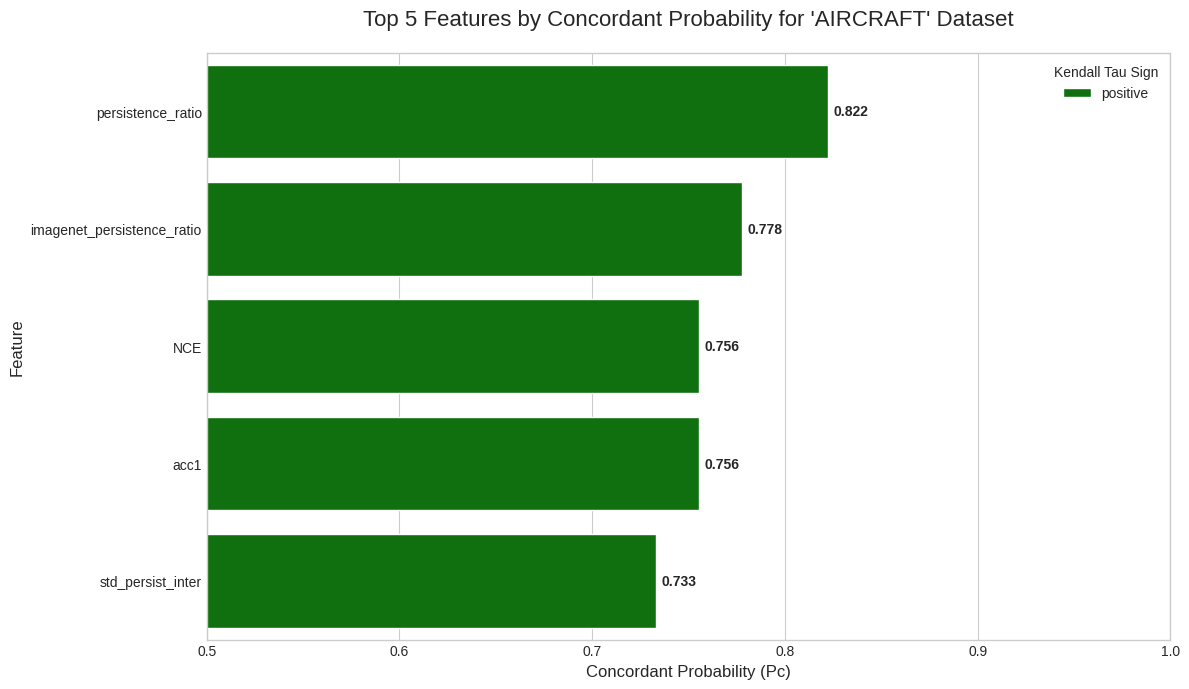


--- Plotting for task: birdsnap ---
Top 5 correlated features:
                            kendall_tau  concordant_probability      sign
measure                                                                  
persistence_ratio              0.733333                0.866667  positive
imagenet_persistence_ratio     0.688889                0.844444  positive
NCE                            0.644444                0.822222  positive
std_persist_inter              0.555556                0.777778  positive
LogME                          0.466667                0.733333  positive


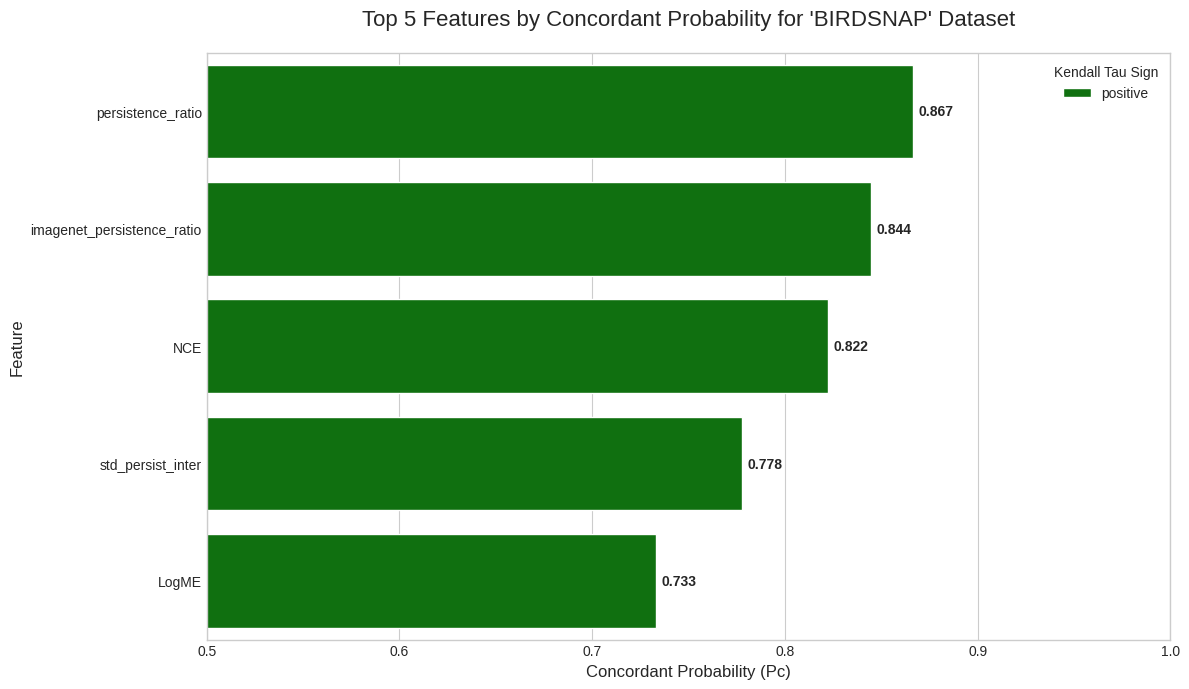


--- Plotting for task: caltech101 ---
Top 5 correlated features:
                            kendall_tau  concordant_probability      sign
measure                                                                  
NCE                            0.733333                0.866667  positive
persistence_ratio              0.733333                0.866667  positive
NC1                            0.688889                0.844444  positive
imagenet_persistence_ratio     0.688889                0.844444  positive
acc1                           0.644444                0.822222  positive


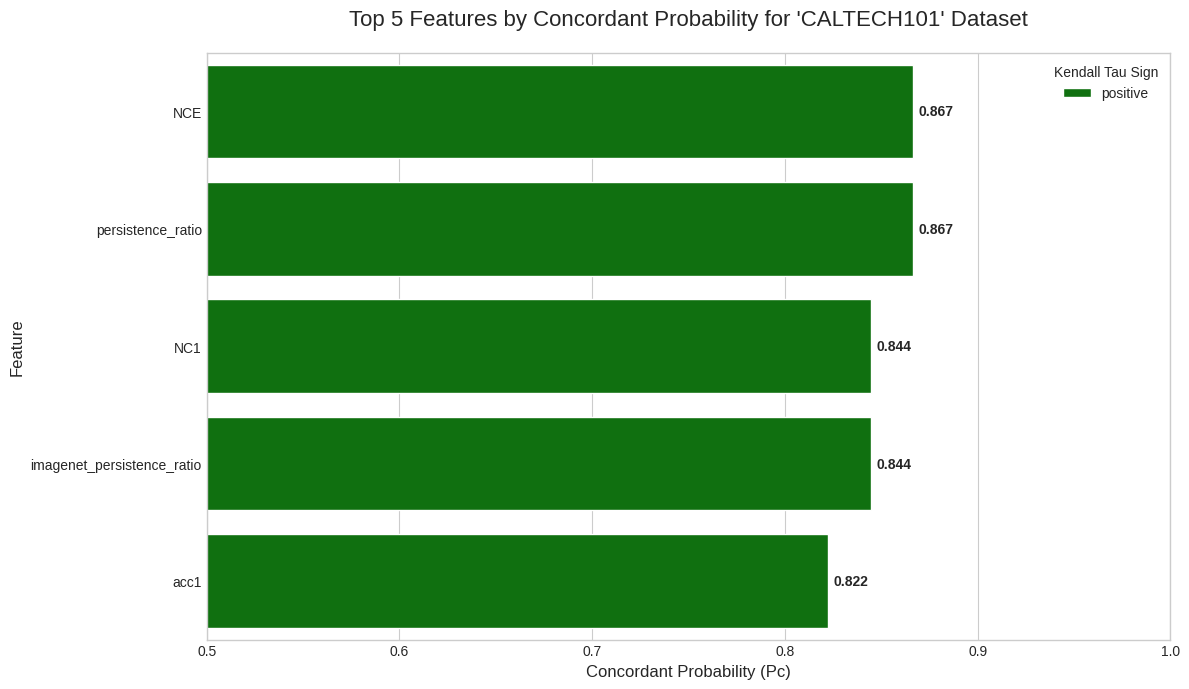


--- Plotting for task: stanfordcars ---
Top 5 correlated features:
                            kendall_tau  concordant_probability      sign
measure                                                                  
imagenet_persistence_ratio     0.659966                0.829983  positive
acc1                           0.612826                0.806413  positive
NCE                            0.565685                0.782843  positive
LogME                          0.518545                0.759272  positive
LEEP                           0.424264                0.712132  positive


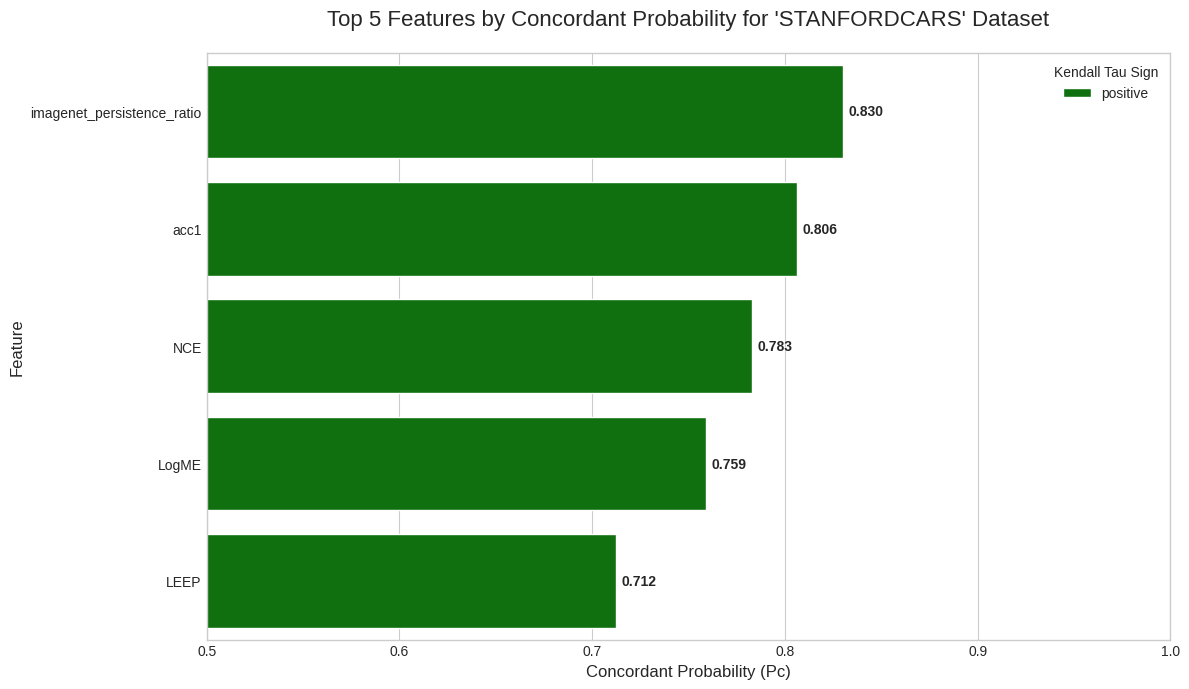


--- Plotting for task: cifar10 ---
Top 5 correlated features:
                            kendall_tau  concordant_probability      sign
measure                                                                  
acc1                           0.841126                0.920563  positive
NC1                            0.795660                0.897830  positive
LogME                          0.704727                0.852364  positive
imagenet_persistence_ratio     0.613795                0.806897  positive
LEEP                           0.477396                0.738698  positive


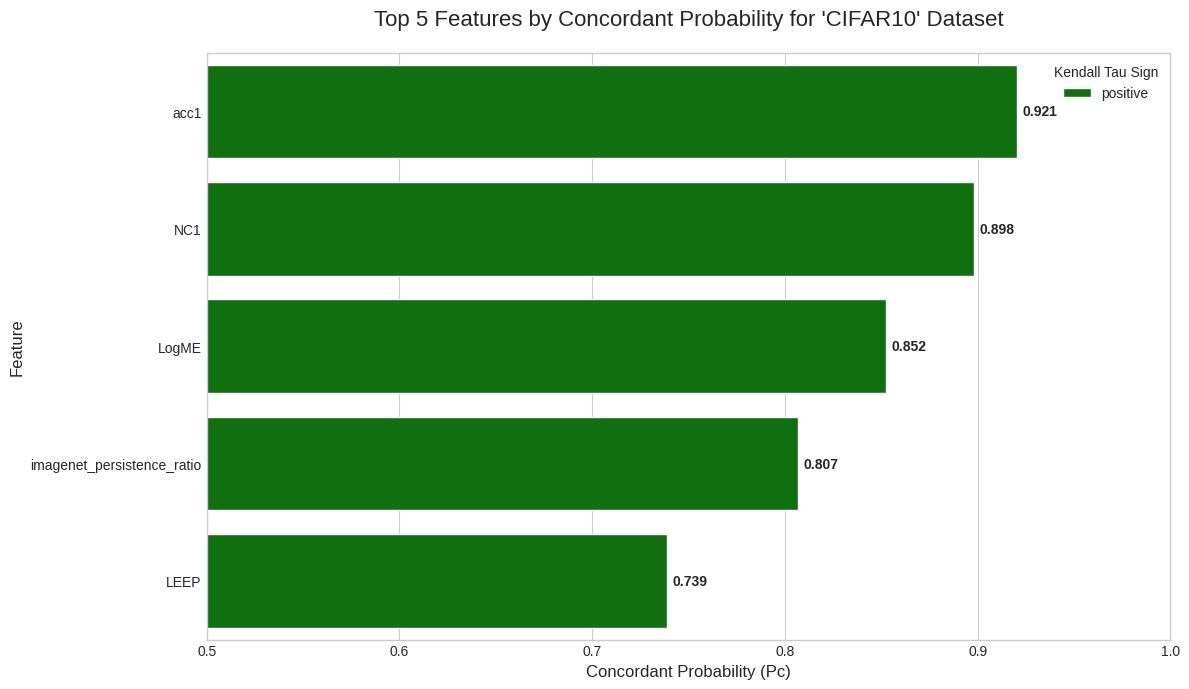


--- Plotting for task: cifar100 ---
Top 5 correlated features:
                            kendall_tau  concordant_probability      sign
measure                                                                  
acc1                           0.866667                0.933333  positive
imagenet_persistence_ratio     0.644444                0.822222  positive
LogME                          0.629253                0.814627  positive
NC1                            0.466667                0.733333  positive
imagenet_std_persist_inter     0.466667                0.733333  positive


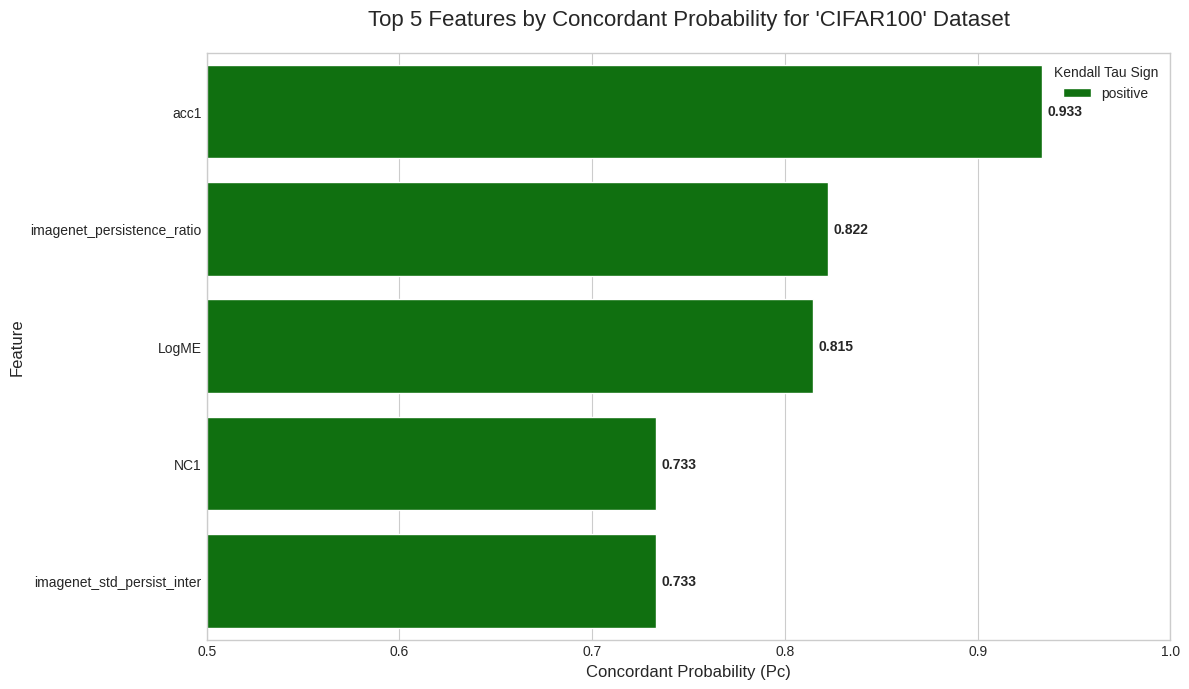


--- Plotting for task: dtd ---
Top 5 correlated features:
                            kendall_tau  concordant_probability      sign
measure                                                                  
imagenet_persistence_ratio     0.688889                0.844444  positive
persistence_ratio             -0.555556                0.777778  negative
acc1                           0.555556                0.777778  positive
LogME                          0.494413                0.747207  positive
imagenet_std_persist_inter     0.333333                0.666667  positive


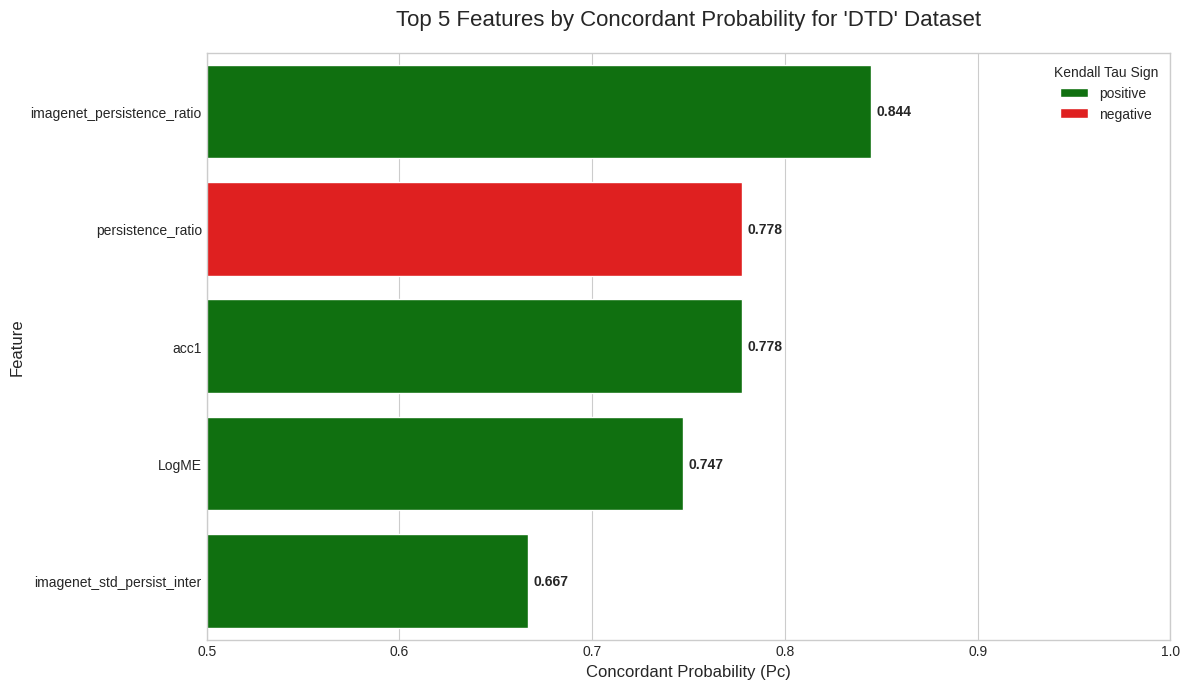


--- Plotting for task: pets ---
Top 5 correlated features:
                            kendall_tau  concordant_probability      sign
measure                                                                  
NCE                            0.733333                0.866667  positive
std_persist_inter              0.688889                0.844444  positive
acc1                           0.688889                0.844444  positive
NC1                            0.555556                0.777778  positive
imagenet_persistence_ratio     0.555556                0.777778  positive


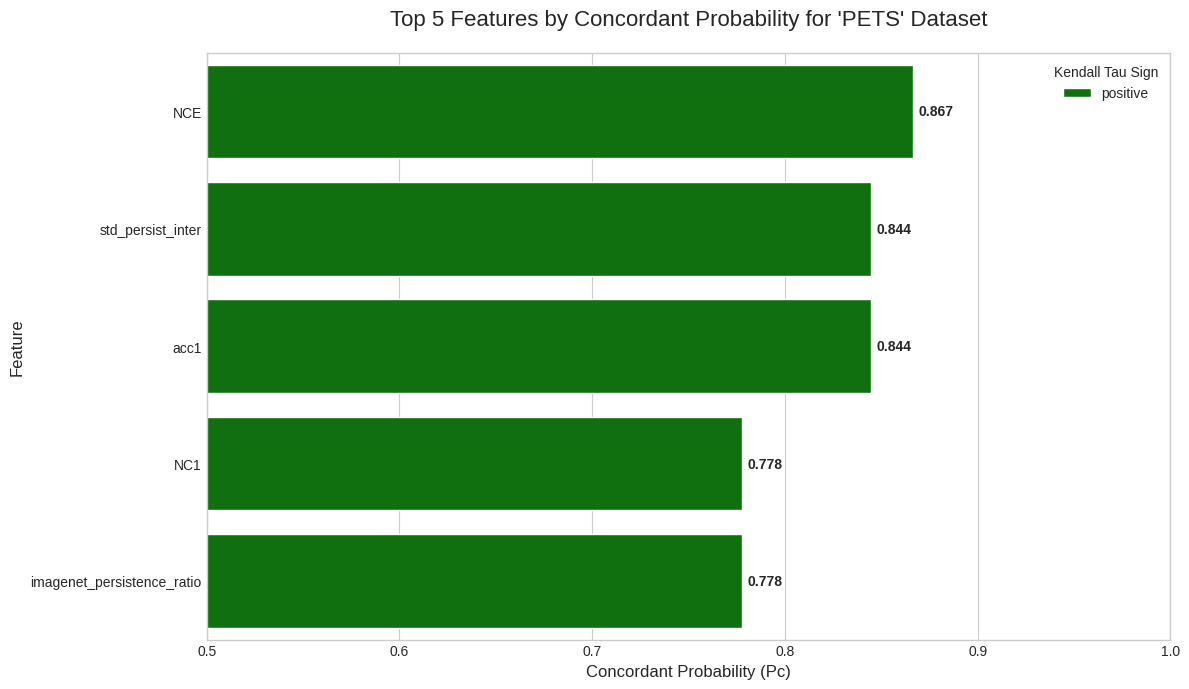


--- Plotting for task: sun397 ---
Top 5 correlated features:
                            kendall_tau  concordant_probability      sign
measure                                                                  
acc1                           0.853986                0.926993  positive
imagenet_persistence_ratio     0.809040                0.904520  positive
NCE                            0.764093                0.882047  positive
LogME                          0.719147                0.859573  positive
NC1                            0.494413                0.747207  positive


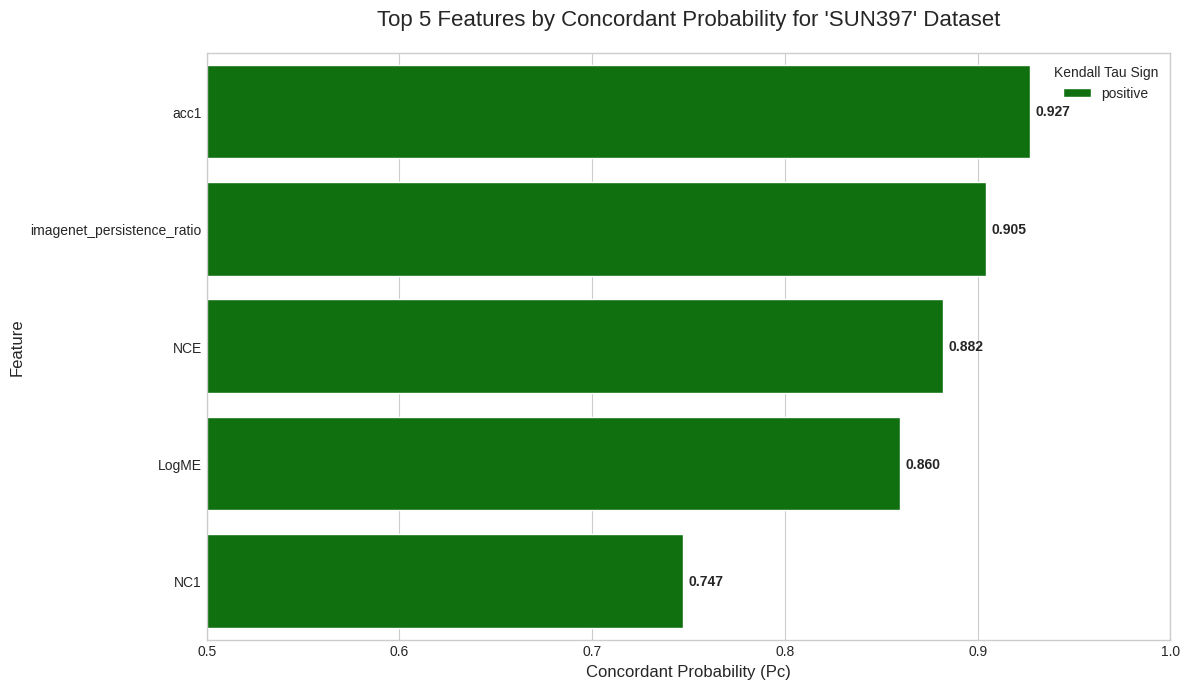

In [19]:


import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*35)
print("Generating Correlation Plots")
print("="*35)

# A check to ensure the data exists before trying to plot
if 'correlation_results' not in locals() and 'correlation_results' not in globals():
    print("\nERROR: The 'correlation_results' dictionary was not found.")
    print("Please ensure the first script has been run successfully.")
else:
    # Iterate through the dictionary to plot each task's results
    for task_name, result_df in correlation_results.items():
        print(f"\n--- Plotting for task: {task_name} ---")

        # --- 1. Select Top 5 Features and Prepare Data ---
        # Find the top 5 features based on the largest *absolute* Kendall's Tau
        top_5_features_index = result_df['kendall_tau'].abs().nlargest(5).index

        # Filter the DataFrame to get only the data for these top 5 features
        plot_data = result_df.loc[top_5_features_index, ['kendall_tau', 'concordant_probability']]

        # Add a 'sign' column to determine the color of the bars
        plot_data['sign'] = ['positive' if tau >= 0 else 'negative' for tau in plot_data['kendall_tau']]

        print("Top 5 correlated features:")
        print(plot_data)

        # --- 2. Generate the Plot ---
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 7))

        # Create the horizontal bar plot, plotting only concordant_probability
        # and coloring by the sign of the kendall_tau.
        sns.barplot(
            data=plot_data,
            y=plot_data.index,
            x='concordant_probability',
            hue='sign',
            palette={'positive': 'g', 'negative': 'r'}, # green for positive, red for negative
            dodge=False, # This is important to have single bars
            ax=ax
        )

        # --- 3. Add Titles and Labels ---
        ax.set_title(f"Top 5 Features by Concordant Probability for '{task_name.upper()}' Dataset", fontsize=16, pad=20)
        ax.set_xlabel("Concordant Probability (Pc)", fontsize=12)
        ax.set_ylabel("Feature", fontsize=12)
        ax.legend(title='Kendall Tau Sign')

        # --- 4. Set Axis Limits and Add Annotations ---
        ax.set_xlim(0.5, 1.0) # The range of concordant probability

        # Add the value text on each bar
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', label_type='edge', padding=4, fontsize=10, weight='bold')

        plt.tight_layout()
        plt.show()


Mean Correlation & Pairwise Accuracy Across All Datasets
                            mean_kendall_tau  mean_pairwise_accuracy
measure                                                             
acc1                                0.671252                0.835626
imagenet_persistence_ratio          0.656114                0.828057
LogME                               0.554194                0.777097
NCE                                 0.437039                0.718520
imagenet_std_persist_inter          0.421617                0.710808
NC1                                 0.397889                0.698945
LEEP                                0.367409                0.683705
std_persist_inter                   0.330841                0.665420
persistence_ratio                   0.321670                0.660835
imagenet_avg_persist_inter          0.102084                0.551042
avg_persist_inter                   0.096530                0.548265
imagenet_avg_persist_intra         -0.012903 

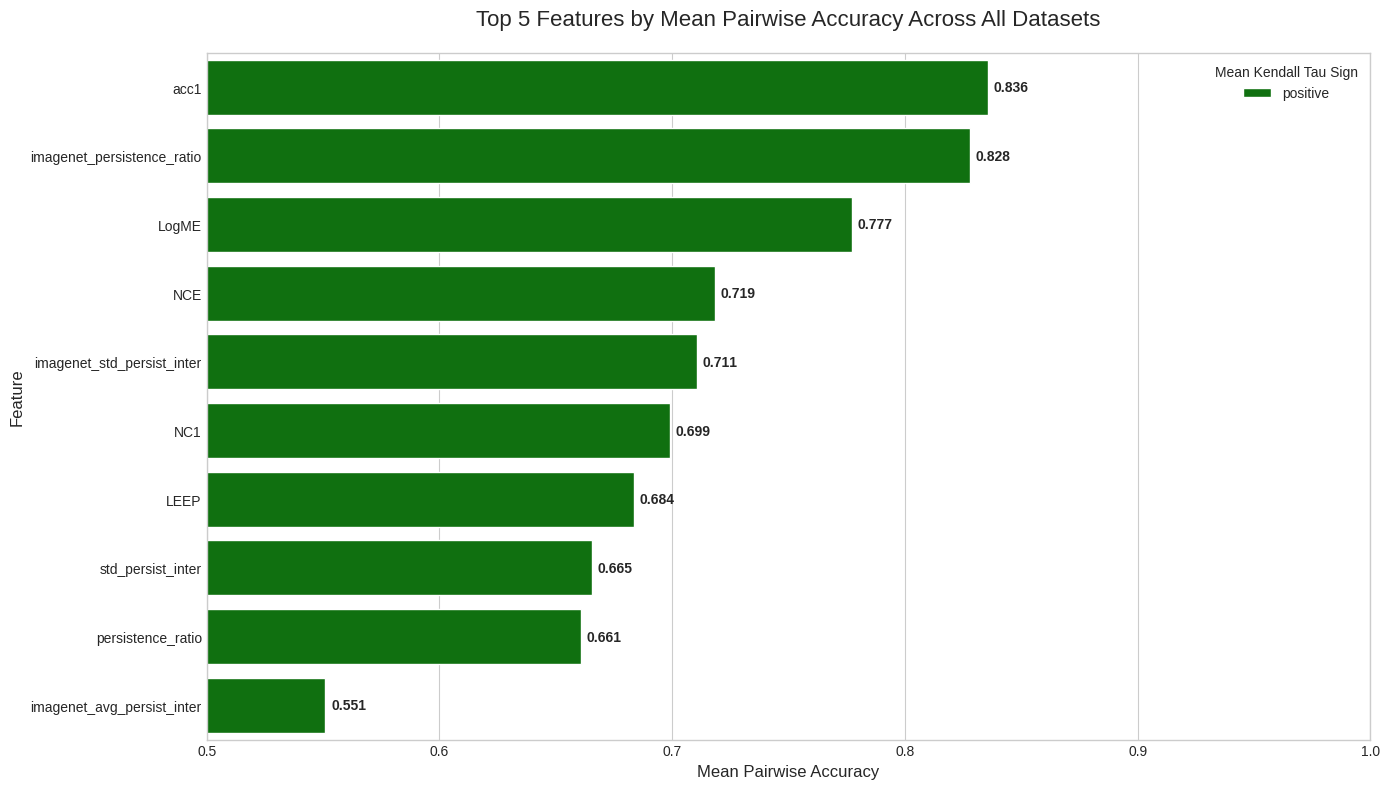

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'correlation_results' dictionary from your previous script is available
if 'correlation_results' not in locals() and 'correlation_results' not in globals():
    print("\nERROR: 'correlation_results' dictionary not found.")
else:
    # --- 1. Compute Mean Tau and derive Mean Pairwise Accuracy ---
    all_taus = [df['kendall_tau'].rename(task) for task, df in correlation_results.items()]
    combined_df = pd.concat(all_taus, axis=1)

    # Create a new DataFrame with the mean calculations
    mean_correlation_df = pd.DataFrame(index=combined_df.index)
    mean_correlation_df['mean_kendall_tau'] = combined_df.mean(axis=1)

    # Derive pairwise accuracy from the mean_kendall_tau for correct interpretation
    mean_correlation_df['mean_pairwise_accuracy'] = (mean_correlation_df['mean_kendall_tau'].abs() + 1) / 2

    print("\n" + "="*55)
    print("Mean Correlation & Pairwise Accuracy Across All Datasets")
    print("="*55)
    print(mean_correlation_df.sort_values(by='mean_pairwise_accuracy', ascending=False))

    # --- 2. Select Top 5 Features and Prepare for Plotting ---
    print("\n--- Plotting Mean Performance ---")

    # Select top 5 features based on the highest predictive power
    top_5_features = mean_correlation_df.nlargest(10, 'mean_pairwise_accuracy')

    # Add a 'sign' column based on the mean_kendall_tau
    top_5_features['sign'] = ['positive' if tau >= 0 else 'negative' for tau in top_5_features['mean_kendall_tau']]

    print("\nTop 5 features by Mean Pairwise Accuracy:")
    print(top_5_features)

    # --- 3. Generate the Bar Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    sns.barplot(
        data=top_5_features,
        y=top_5_features.index,
        x='mean_pairwise_accuracy',
        hue='sign',
        palette={'positive': 'g', 'negative': 'r'},
        dodge=False,
        ax=ax
    )

    ax.set_title("Top 5 Features by Mean Pairwise Accuracy Across All Datasets", fontsize=16, pad=20)
    ax.set_xlabel("Mean Pairwise Accuracy", fontsize=12)
    ax.set_ylabel("Feature", fontsize=12)
    ax.legend(title='Mean Kendall Tau Sign')

    # Set x-axis limits to accommodate all values
    ax.set_xlim(0.5, 1.0)

    # Add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', padding=4, fontsize=10, weight='bold')

    plt.tight_layout()
    plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Times
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Times
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Times
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Times
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Times
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Times
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Times
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman, Times
findfont: Generic family 'serif' not found because none of the f

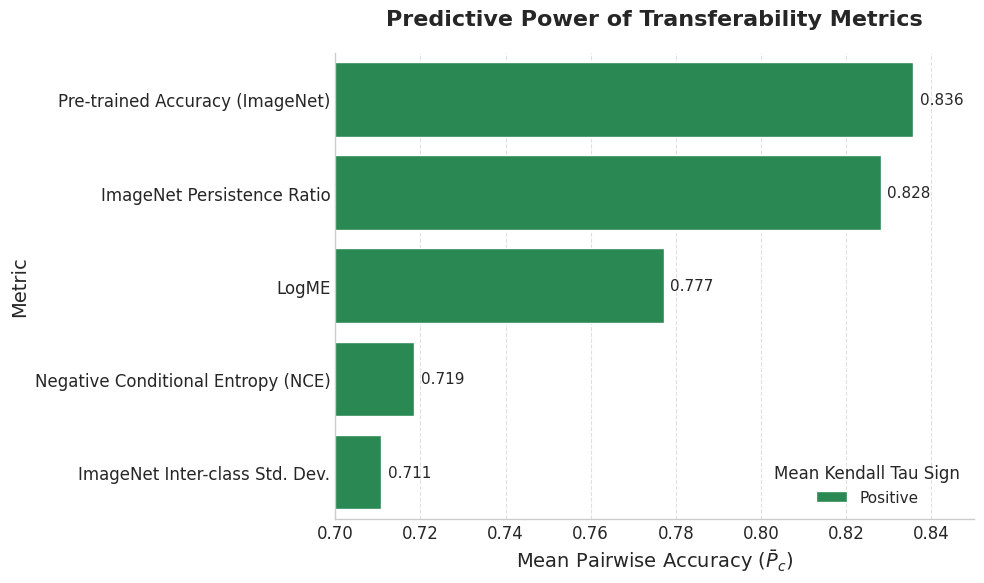

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import seaborn as sns

# This block recreates the 'mean_correlation_df' DataFrame from your notebook.
# It assumes the 'correlation_results' dictionary is already in memory.
# ==============================================================================
if 'correlation_results' in locals() or 'correlation_results' in globals():
    all_taus = [df['kendall_tau'].rename(task) for task, df in correlation_results.items()]
    combined_df = pd.concat(all_taus, axis=1)

    mean_correlation_df = pd.DataFrame(index=combined_df.index)
    mean_correlation_df['mean_kendall_tau'] = combined_df.mean(axis=1)
    mean_correlation_df['mean_pairwise_accuracy'] = (mean_correlation_df['mean_kendall_tau'].abs() + 1) / 2
# ==============================================================================

    # --- Publication-Ready Visualization Code ---

    # 1. Set style and font parameters for publication quality
    # Ensures fonts are embedded correctly in the PDF output for NeurIPS compliance.
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times"],
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 11,
        "figure.figsize": (10, 6), # Standard figure size
        "pdf.fonttype": 42, # Embeds fonts as TrueType
        "ps.fonttype": 42
    })

    # 2. Select the top 5 features and create human-readable labels
    top_5_features = mean_correlation_df.nlargest(5, 'mean_pairwise_accuracy')

    # Map variable names to publication-quality labels
    label_mapping = {
        'acc1': 'Pre-trained Accuracy (ImageNet)',
        'imagenet_persistence_ratio': 'ImageNet Persistence Ratio',
        'LogME': 'LogME',
        'NCE': 'Negative Conditional Entropy (NCE)',
        'imagenet_std_persist_inter': 'ImageNet Inter-class Std. Dev.'
    }
    top_5_features.rename(index=label_mapping, inplace=True)

    # Add a 'sign' column for coloring, with capitalized labels for the legend
    top_5_features['sign'] = ['Positive' if tau >= 0 else 'Negative' for tau in top_5_features['mean_kendall_tau']]

    # 3. Generate the plot
    fig, ax = plt.subplots()

    # Define a more professional, color-blind friendly palette
    palette = {'Positive': '#1a9850', 'Negative': '#d73027'}

    sns.barplot(
        data=top_5_features,
        y=top_5_features.index,
        x='mean_pairwise_accuracy',
        hue='sign',
        palette=palette,
        dodge=False,
        ax=ax
    )

    # 4. Refine titles, labels, and overall aesthetics
    ax.set_title("Predictive Power of Transferability Metrics", fontsize=16, pad=20, weight='bold')
    # Using LaTeX for the mathematical symbol for mean pairwise accuracy
    ax.set_xlabel(r"Mean Pairwise Accuracy ($\bar{P}_c$)", fontsize=14)
    ax.set_ylabel("Metric", fontsize=14)
    ax.legend(title='Mean Kendall Tau Sign', loc='lower right')

    # Adjust x-axis limits to focus on the data range for better readability
    ax.set_xlim(0.7, 0.85)
    ax.grid(axis='x', linestyle='--', alpha=0.6) # Lighter grid lines

    # Remove unnecessary top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 5. Add precise data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=5, fontsize=11)

    # 6. Save the figure in multiple high-quality formats
    plt.tight_layout()
    plt.savefig("neurips_mean_accuracy_plot.pdf", bbox_inches='tight')
    plt.savefig("neurips_mean_accuracy_plot.svg", bbox_inches='tight')
    plt.show()

else:
    print("\\nERROR: The 'correlation_results' dictionary was not found.")

In [22]:
if 'correlation_results' in locals() or 'correlation_results' in globals():
    # Use a dictionary comprehension to extract the 'kendall_tau' series for each task
    all_taus = {task: df['kendall_tau'] for task, df in correlation_results.items()}

    # Create a DataFrame from the dictionary of series
    summary_df = pd.DataFrame(all_taus)

    # Transpose the DataFrame so that tasks are rows and measures are columns
    summary_df_transposed = summary_df.transpose()

    print("\\n" + "="*60)
    print("Summary Table: Kendall Tau Correlation for All Tasks")
    print("="*60)

    # Display the transposed DataFrame
    print(summary_df_transposed)

else:
    print("\\nERROR: The 'correlation_results' dictionary was not found.")
    print("Please ensure the previous scripts have been run successfully.")

\n============================================================
Summary Table: Kendall Tau Correlation for All Tasks
measure           LEEP       NCE     LogME       NC1  avg_persist_inter  \
aircraft      0.288889  0.511111  0.359573 -0.244444          -0.155556   
birdsnap      0.333333  0.644444  0.466667  0.422222          -0.244444   
caltech101    0.422222  0.733333  0.584307  0.688889           0.200000   
stanfordcars  0.424264  0.565685  0.518545  0.424264          -0.141421   
cifar10       0.477396  0.159132  0.704727  0.795660           0.386463   
cifar100      0.422222  0.111111  0.629253  0.466667           0.377778   
dtd           0.022222 -0.288889  0.494413 -0.022222           0.066667   
pets          0.466667  0.733333  0.511111  0.555556           0.244444   
sun397        0.449467  0.764093  0.719147  0.494413           0.134840   

measure       std_persist_inter  avg_persist_intra  persistence_ratio  \
aircraft               0.466667          -0.422222          

In [23]:
if 'correlation_results' in locals() or 'correlation_results' in globals():
    # Create an empty dictionary to store the agreement coefficient series
    all_agreements = {}

    # Iterate through each task in the correlation_results dictionary
    for task, df in correlation_results.items():
        # Apply the transformation (tau + 1) / 2 to the kendall_tau column
        agreement_coefficient = (df['kendall_tau'] + 1) / 2
        all_agreements[task] = agreement_coefficient

    # Create a DataFrame from the dictionary of series
    agreement_df = pd.DataFrame(all_agreements)

    # Transpose the DataFrame so that tasks are rows and measures are columns
    agreement_df_transposed = agreement_df.transpose()

    print("\\n" + "="*70)
    print("Summary Table: Agreement Coefficient (tau + 1) / 2 for All Tasks")
    print("="*70)

    # Display the transposed DataFrame
    print(agreement_df_transposed)

else:
    print("\\nERROR: The 'correlation_results' dictionary was not found.")
    print("Please ensure the previous scripts have been run successfully.")

\n======================================================================
Summary Table: Agreement Coefficient (tau + 1) / 2 for All Tasks
measure           LEEP       NCE     LogME       NC1  avg_persist_inter  \
aircraft      0.644444  0.755556  0.679787  0.377778           0.422222   
birdsnap      0.666667  0.822222  0.733333  0.711111           0.377778   
caltech101    0.711111  0.866667  0.792153  0.844444           0.600000   
stanfordcars  0.712132  0.782843  0.759272  0.712132           0.429289   
cifar10       0.738698  0.579566  0.852364  0.897830           0.693232   
cifar100      0.711111  0.555556  0.814627  0.733333           0.688889   
dtd           0.511111  0.355556  0.747207  0.488889           0.533333   
pets          0.733333  0.866667  0.755556  0.777778           0.622222   
sun397        0.724733  0.882047  0.859573  0.747207           0.567420   

measure       std_persist_inter  avg_persist_intra  persistence_ratio  \
aircraft               0.733333       

In [24]:
agreement_df_transposed[['LEEP', 'NCE', 'LogME', 'acc1', 'persistence_ratio', 'imagenet_persistence_ratio']].to_csv('kendall_tau.csv')

In [26]:
import pandas as pd
from scipy.stats import kendalltau, spearmanr
import numpy as np

# --- This block assumes 'final_results_df' has been created ---
# --- and includes the 'NC1' column from the previous steps. ---

if 'final_results_df' in locals() or 'final_results_df' in globals():

    # 1. Define the metrics for the analysis
    # Use original names for display in the table rows
    display_names = [
        'LEEP',
        'NCE',
        'LogME',
        'Pre-trained Acc.',
        'Persistence Ratio',
        'ImageNet PR',
        'NC1'
    ]

    # Use the corrected column names for calculation (with negated versions)
    # This ensures a higher correlation value is always better.
    calculation_cols = [
        'LEEP',
        'NCE',
        'LogME',
        'acc1',
        'persistence_ratio',
        'imagenet_persistence_ratio',
        'NC1'
    ]

    # Get the list of unique tasks (datasets) to form the table columns
    unique_tasks = final_results_df['task'].unique()

    # 2. Create functions to calculate and format the tables
    def create_correlation_table(corr_func):
        """Calculates a correlation matrix for all tasks and metrics."""
        # Initialize a DataFrame to store the correlation values
        corr_df = pd.DataFrame(index=display_names, columns=unique_tasks)

        for task in unique_tasks:
            # Filter the main DataFrame for the current task
            task_df = final_results_df[final_results_df['task'] == task]

            for display_name, col_name in zip(display_names, calculation_cols):
                if col_name in task_df.columns:
                    # Calculate correlation between the metric and target accuracy
                    accuracy_values = task_df['Accuracy']
                    measure_values = task_df[col_name]

                    # Use the provided correlation function (kendall or spearman)
                    correlation, _ = corr_func(accuracy_values, measure_values)
                    corr_df.loc[display_name, task] = correlation
                else:
                    corr_df.loc[display_name, task] = np.nan

        # Add a 'Mean' column that averages the correlations across all tasks
        corr_df['Mean'] = corr_df.mean(axis=1)
        return corr_df.astype(float)

    # 3. Generate the three requested tables

    # Table 1: Kendall's Tau
    kendall_table = create_correlation_table(kendalltau)

    # Table 2: Concordant Probability (derived from Kendall's Tau)
    # This is the correct transformation for pairwise accuracy
    concordant_prob_table = (kendall_table + 1) / 2

    # Table 3: Spearman's Rho
    spearman_table = create_correlation_table(spearmanr)

    # 4. Print the formatted tables
    print("\\n" + "="*80)
    print("Table 1: Kendall's Tau Correlation with Target Accuracy")
    print("="*80)
    print(kendall_table.to_string(float_format="%.3f"))

    print("\\n" + "="*80)
    print("Table 2: Concordant Probability (Pairwise Accuracy)")
    print("="*80)
    print(concordant_prob_table.to_string(float_format="%.3f"))

    print("\\n" + "="*80)
    print("Table 3: Spearman's Rho Correlation with Target Accuracy")
    print("="*80)
    print(spearman_table.to_string(float_format="%.3f"))

else:
    print("\\nERROR: The 'final_results_df' DataFrame was not found.")
    print("Please ensure all previous cells, including data loading and NC1 calculation,")
    print("have been run successfully before executing this cell.")

\n================================================================================
Table 1: Kendall's Tau Correlation with Target Accuracy
                   aircraft  birdsnap  caltech101  stanfordcars  cifar10  cifar100    dtd  pets  sun397  Mean
LEEP                  0.289     0.333       0.422         0.424    0.477     0.422  0.022 0.467   0.449 0.367
NCE                   0.511     0.644       0.733         0.566    0.159     0.111 -0.289 0.733   0.764 0.437
LogME                 0.360     0.467       0.584         0.519    0.705     0.629  0.494 0.511   0.719 0.554
Pre-trained Acc.      0.511     0.467       0.644         0.613    0.841     0.867  0.556 0.689   0.854 0.671
Persistence Ratio     0.644     0.733       0.733         0.283    0.341    -0.067 -0.556 0.378   0.405 0.322
ImageNet PR           0.556     0.689       0.689         0.660    0.614     0.644  0.689 0.556   0.809 0.656
NC1                  -0.244     0.422       0.689         0.424    0.796     0.467 -0.022 0

In [29]:
kendall_table.transpose()

,LEEP,NCE,LogME,Pre-trained Acc.,Persistence Ratio,ImageNet PR,NC1
aircraft,0.288889,0.511111,0.359573,0.511111,0.644444,0.555556,-0.244444
birdsnap,0.333333,0.644444,0.466667,0.466667,0.733333,0.688889,0.422222
caltech101,0.422222,0.733333,0.584307,0.644444,0.733333,0.688889,0.688889
stanfordcars,0.424264,0.565685,0.518545,0.612826,0.282843,0.659966,0.424264
cifar10,0.477396,0.159132,0.704727,0.841126,0.340997,0.613795,0.795660
cifar100,0.422222,0.111111,0.629253,0.866667,-0.066667,0.644444,0.466667
dtd,0.022222,-0.288889,0.494413,0.555556,-0.555556,0.688889,-0.022222
pets,0.466667,0.733333,0.511111,0.688889,0.377778,0.555556,0.555556
sun397,0.449467,0.764093,0.719147,0.853986,0.404520,0.809040,0.494413
Mean,0.367409,0.437039,0.554194,0.671252,0.321670,0.656114,0.397889
